In [1]:
import pints
import pints.toy as toy
import pints.plot

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
import emupints.metrics as emumet

import numpy as np
import matplotlib.pyplot as plt
import GPy
from GPy import kern as kern

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import string
from itertools import product

## Specifying model

In [2]:
# Load problem from predefined ones
model = emupints.Problems.SIRModel
problem = emupints.Problems.load_problem(model)

problem['values'][:5]

array([[ 0.87001731, -2.57789448],
       [ 0.69728435, -1.21189818],
       [ 1.45654405,  0.40010721],
       [ 1.3411845 , -2.36094839],
       [ 1.75826514, -0.83347473]])

In [3]:
# take all the required variables from the problem
n_parameters = problem['n_parameters']
log_likelihood = problem['log_likelihood']
log_prior = problem['log_prior']
log_posterior = problem['log_posterior']
real_parameters = problem['parameters']
pints_problem = problem['problem']
bounds = problem['bounds']
index_to_param_name = problem['param_names']

# Apply CMA-ES

In [4]:
# CMA-es
score = pints.SumOfSquaresError(pints_problem)
x0 = bounds.sample(1)[0]

found_parameters, found_value = pints.optimise(
    score,
    x0,
    None,
    bounds,
    method=pints.CMAES
)

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      3116.949   0:00.1
1     14     3116.949   0:00.1
2     21     2759.827   0:00.1
3     28     2182.573   0:00.1
20    147    1271.717   0:00.2
40    287    1271.342   0:00.3
60    427    1269.292   0:00.4
80    567    1269.289   0:00.5
100   707    1269.289   0:00.6
120   847    1269.289   0:00.8
140   987    1269.289   0:00.9
160   1127   1269.289   0:01.0
180   1267   1269.289   0:01.1
200   1407   1269.289   0:01.2
220   1547   1269.289   0:01.3
240   1687   1269.289   0:01.4
260   1827   1269.289   0:01.5
280   1967   1269.289   0:01.7
300   2107   1269.289   0:01.8
310   2170   1269.289   0:01.8
Halting: No significant change for 200 iterations.


# Use found parameters to sample trianing data

In [5]:
# training size
# use bigger training size for NNs because speed stays the same
train_size = 500
test_size = 1000
sampling_std = 0.05 * found_parameters # take 5% around found parameters std

def normal_sampling(size, mean, std):
    return mean + np.random.randn(*size) * std

# create data for training and testing
# genera example using normal distribution around parametrs
train_X = normal_sampling((train_size, n_parameters), found_parameters, sampling_std)
train_y = np.apply_along_axis(log_likelihood, 1, train_X)

# if provide validation data to keras model also need to normalize it 
test_X = normal_sampling((test_size, n_parameters), found_parameters, sampling_std)
test_y = np.apply_along_axis(log_likelihood, 1, test_X)

## Creating GP and selecting kernel

In [6]:
emu = emupints.GPEmulator(log_likelihood,
                          train_X,
                          train_y,
                          input_scaler=StandardScaler(),
                         )

In [7]:
n_parameters = emu.n_parameters()


kernels = [
    kern.Linear(n_parameters),
    kern.RBF(n_parameters),
    kern.RatQuad(n_parameters),
    kern.MLP(n_parameters),
    kern.Matern52(n_parameters),
    kern.RatQuad(n_parameters) + kern.RBF(n_parameters),
    kern.Matern52(n_parameters) + kern.RBF(n_parameters),
    kern.RatQuad(n_parameters) + kern.RBF(n_parameters),
    kern.MLP(n_parameters) + kern.Matern52(n_parameters) + kern.RatQuad(n_parameters),
]

kernel_names = [
    'Linear',
    'RBF',
    'RatQuad',
    'MLP',
    'Matern',
    'RatQuad + RBF',
    'Matern52 + RBF',
    'RatQuad + RBF',
    'MLP + Matern + RatQuad'
]

# kernels that have been optimized for input data
trained_kernels = []

# possible optimizers: 
# ‘scg’, ‘lbfgs’, ‘tnc’
# can specify max number of iterations using max_iters
optimizer = "lbfgs"
max_iters = 500
emu.set_parameters(optimizer = optimizer)

In [8]:
# when the output data is normalized values of variance should be small
# hence ignore any kernel that has a subkernel 
# (i.e kernel that is a part of sum/product) 
# with variance > 1000
# set avoid_overfitting to False to stop this effect
avoid_overfitting = False
variance_threshold = 1000

# store prediction time for comparison
likelihood_time = %timeit -o log_likelihood(real_parameters)
likelihood_time = likelihood_time.average

634 µs ± 42 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
marginal_likelihoods = []
prediction_times = []

for kernel, kernel_name in zip(kernels, kernel_names):
    emu.set_parameters(kernel = kernel)
    emu.fit(optimize = False, normalizer = True)
    emu.optimize(max_iters = max_iters, messages = False)

    trained_kernel = emu.get_trained_kern()
    trained_kernels.append(trained_kernel)

    # time prediction
    emu_time =  %timeit -o emu(real_parameters)
    prediction_times.append(emu_time.average)

    ml = emu.get_log_marginal_likelihood()
    marginal_likelihoods.append(ml)
    print("{}: {:.2f}".format(kernel_name, ml))

349 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Linear: -686.07
429 µs ± 25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RBF: 84.63


 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:676: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:681: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:683: RuntimeWarning:invalid value encountered in multiply
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:688: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:690: RuntimeWarning:invalid value encountered in multiply


430 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad: 84.47
515 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
MLP: 79.84
438 µs ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Matern: 82.25
794 µs ± 29.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad + RBF: 85.40
745 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Matern52 + RBF: 85.39
753 µs ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
RatQuad + RBF: 85.40


 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:overflow encountered in multiply
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:676: RuntimeWarning:overflow encountered in square


1.17 ms ± 91.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
MLP + Matern + RatQuad: 85.32


In [10]:
best_kernel = None
best_score = -1 << 31
best_time = -1 << 31

# find kernel with highest log marginal likelihood
for kernel, score, emu_time in zip(trained_kernels, marginal_likelihoods, prediction_times):
    # ignore any overfitting kernel
    if avoid_overfitting and emutils.has_high_variance(kernel, threshold = variance_threshold):
        continue
    
    # avoid kernels that don't provide 5x speed up
    #if 5 * emu_time > likelihood_time:
    #    continue

    if score > best_score:
        best_kernel = kernel
        best_time = emu_time
        best_score = best_score
        
print('Prediction time: ', best_time)
best_kernel

Prediction time:  0.0011674670121366423


sum.,value,constraints,priors
mlp.variance,27.904931312391852,+ve,
mlp.weight_variance,4.0307402852091656e-61,+ve,
mlp.bias_variance,41.5501479217183,+ve,
Mat52.variance,321.01047323555633,+ve,
Mat52.lengthscale,207.17567980912477,+ve,
RatQuad.variance,503.38790040586116,+ve,
RatQuad.lengthscale,141.7743755430985,+ve,
RatQuad.power,238.38299343129466,+ve,


In [11]:
emu.set_parameters(kernel = kernels[3])
emu.fit(optimize = False, normalizer = True)
emu.optimize(max_iters = max_iters, messages = True)    

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s15  004   1.266875e+02   3.194154e+04 
    00s19  005  -7.952807e+01   1.357061e+02 

 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



    02s25  065  -7.983771e+01   9.833177e-02 
    03s63  125  -7.983778e+01   9.824937e-02 
Runtime:     03s63
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'



In [12]:
emu.get_gp()

GP_regression.,value,constraints,priors
mlp.variance,1002115.3515415029,+ve,
mlp.weight_variance,0.013901801418680476,+ve,
mlp.bias_variance,608902.741262328,+ve,
Gaussian_noise.variance,0.03243269273091728,+ve,


# Likelihood metrics

In [13]:
emu_time = %timeit -r 50 -o emu(real_parameters)
print("Emulator prediction time (micro-seconds): {:5f}".format(emu_time.average * 1000000))

488 µs ± 14.6 µs per loop (mean ± std. dev. of 50 runs, 1000 loops each)
Emulator prediction time (micro-seconds): 488.098376


In [14]:
likelihood_time = %timeit -r 50 -o log_likelihood(real_parameters)
print("Likelihood prediction time (micro-seconds): {:5f}".format(likelihood_time.average * 1000000))

566 µs ± 7.82 µs per loop (mean ± std. dev. of 50 runs, 1000 loops each)
Likelihood prediction time (micro-seconds): 566.415250


In [15]:
pred_y = np.apply_along_axis(emu, 1, test_X)
print("Mean absolute error (mae): {:.5f}".format(emumet.mae(test_y, pred_y)))

Mean absolute error (mae): 328.77147


In [16]:
print("Mean percentage error (mape): {:.5f}".format(emumet.mape(test_y, pred_y) * 100))

Mean percentage error (mape): 30.91460


# Comparing MCMC run times

In [17]:
mcmc_method = pints.AdaptiveCovarianceMCMC

# MCMC parameters
num_chains = 3
max_iters = 10000

In [18]:
# Create a posterior log-likelihood (log(likelihood * prior))
emu_log_posterior = pints.LogPosterior(emu, log_prior)

In [19]:
xs = [
    found_parameters,
    found_parameters * 1.01,
    found_parameters * 0.99
]
xs

[array([3.00518281e-02, 2.71013538e-01, 3.50669520e+01]),
 array([3.03523464e-02, 2.73723673e-01, 3.54176215e+01]),
 array([2.97513098e-02, 2.68303402e-01, 3.47162825e+01])]

In [20]:
emu_mcmc = pints.MCMCSampling(emu_log_posterior,
                              num_chains,
                              xs,
                              method = mcmc_method,
                             )
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Done!


In [21]:
real_mcmc = pints.MCMCSampling(log_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                               )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

Running...
Done!


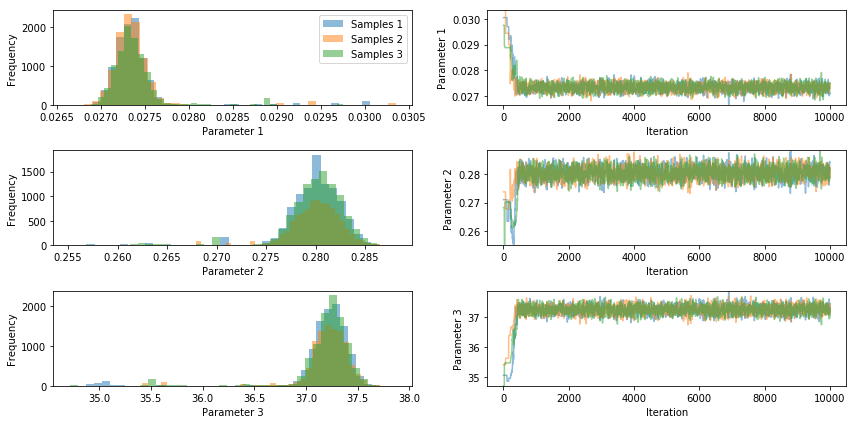

In [22]:
pints.plot.trace(emu_chains)
plt.show()

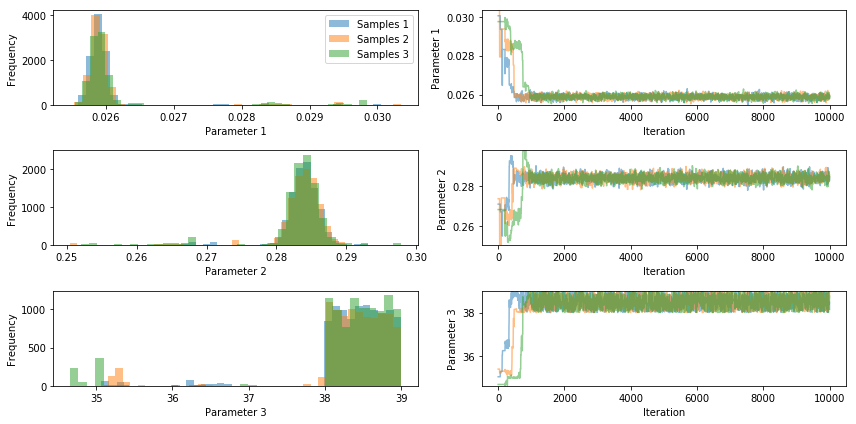

In [23]:
pints.plot.trace(real_chains)
plt.show()

# MCMC metrics

In [24]:
print('Emulator R-hat:')
print(pints.rhat_all_params(emu_chains))

Emulator R-hat:
[1.0001846066241493, 1.0008609839400824, 1.0009399763263143]


In [25]:
print('Real R-hat:')
print(pints.rhat_all_params(real_chains))

Real R-hat:
[1.006828559377062, 1.005864340957345, 1.0061851129057524]


In [26]:
# percentage
chain = real_chains[0]

chain_mape = emumet.chain_mape(chain, emu, log_likelihood)
print("Chain mean absolute percentage error: {:.5f}".format(chain_mape * 100))

Chain mean absolute percentage error: 17.72699


In [27]:
emu_mcmc_time = %timeit -o emu_mcmc.run()
print("Emulator MCMC time: {:.5f}".format(emu_mcmc_time.average))

22.7 s ± 2.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Emulator MCMC time: 22.65593


In [28]:
real_mcmc_time = %timeit -o real_mcmc.run()
print("MCMC time: {:.5f}".format(real_mcmc_time.average))

23.2 s ± 452 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MCMC time: 23.15676


In [29]:
emu_parameters, emu_parameters_std = emumet.estimate_parameters(emu_chains)
print("Emulator estimated parameters: ", emu_parameters)
print("Emulator parametet std: ", emu_parameters_std)

Emulator estimated parameters:  [2.73824165e-02 2.79843420e-01 3.71891596e+01]
Emulator parametet std:  [4.38368832e-05 4.46436756e-04 5.62018874e-02]


In [30]:
real_parameters, real_parameters_std = emumet.estimate_parameters(real_chains)
print("Real estimated parameters: ", real_parameters)
print("Real parameters std: ", real_parameters_std)

Real estimated parameters:  [2.60436578e-02 2.83249107e-01 3.83322665e+01]
Real parameters std:  [1.40875756e-04 1.08109649e-03 1.70033958e-01]


# Plotting emulator surfaces around parameters

In [31]:
# use smaller bounds to get an idea of the surface around real parameters
min_bounds = np.min(chain, axis = 0)
max_bounds = np.max(chain, axis = 0)
bounds = pints.RectangularBoundaries(min_bounds, max_bounds)

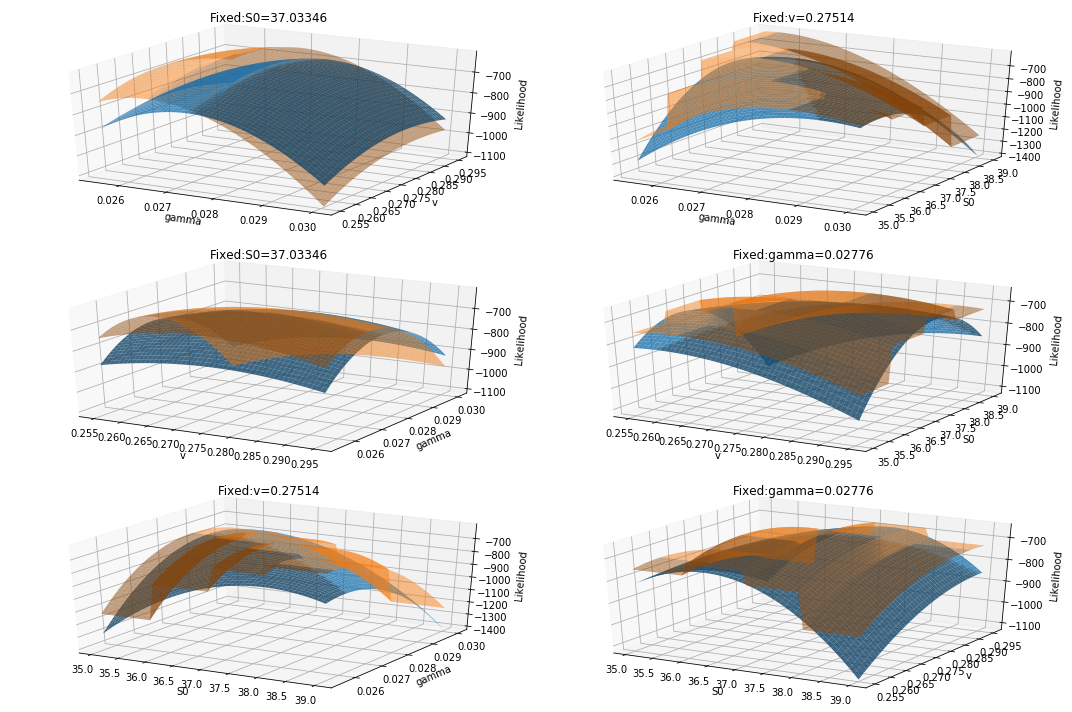

In [32]:
# plot surfaces
if n_parameters >=3:
    fixed_parameters = emutils.fix_parameters(bounds)
    
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        shape = (n_parameters, n_parameters - 1),
        contour = False,
        index_to_param_name=index_to_param_name,
        additional_log_likelihoods = [log_likelihood]
    )

    plt.show(fig)
    
# for row i we have parameter i fixed and some other parameter j, depending on the column, j != i

In [33]:
print(bounds.lower())
print(bounds.upper())

[2.54672000e-02 2.55092471e-01 3.50669520e+01]
[3.00518281e-02 2.95180174e-01 3.89999765e+01]


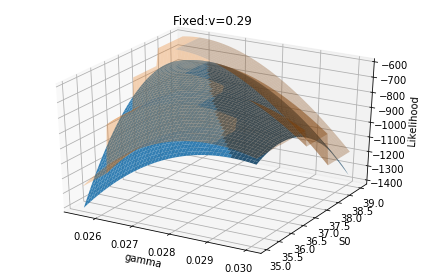

In [34]:
fig, ax = emuplt.plot_surface_fixed_param(
    emu,
    bounds,
    fixed = [(1, 0.29)],
    index_to_param_name=index_to_param_name,
    contour=False,
    precision=2,
    additional_log_likelihoods=[log_likelihood]
)

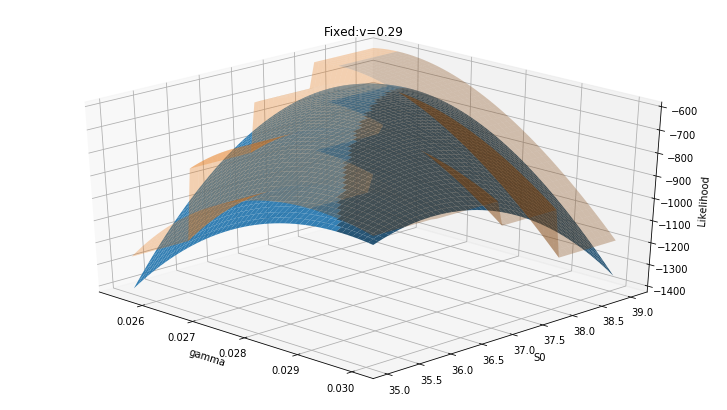

In [35]:
ax.view_init(30, 45 + 90 *3)
fig.set_size_inches(10.5, 6)
fig